https://github.com/gretelai/gretel-synthetics/blob/master/examples/timeseries_dgan.ipynb

In [1]:
# version recommended by source
!pip install torch==1.11.0

     |██████████████▋                 | 342.6 MB 3.7 MB/s eta 0:01:52  

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████▍   | 666.6 MB 10.9 MB/s eta 0:00:08 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
!pip install git+https://github.com/gretelai/gretel-synthetics.git

  Cloning https://github.com/gretelai/gretel-synthetics.git to /tmp/pip-req-build-bnzgl5_k
  Running command git clone --filter=blob:none -q https://github.com/gretelai/gretel-synthetics.git /tmp/pip-req-build-bnzgl5_k
  Resolved https://github.com/gretelai/gretel-synthetics.git to commit 2ed9d31ce8f56afd1519c38859ab081e8cdef579
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 67 kB 32.3 MB/s            
     |████████████████████████████████| 1.2 MB 122.6 MB/s            
     |████████████████████████████████| 58 kB 115.1 MB/s            
     |████████████████████████████████| 251 kB 125.4 MB/s            
     |████████████████████████████████| 6.3 MB 117.0 MB/s            
     |████████████████████████████████| 532 kB 112.3 MB/s            
     |████████████████████████████████| 438 kB 122.8 MB/s            
     |████████████████████████████████| 4.3 MB 61.2 MB/s            
     |████████████████████████████████| 142 kB 137.9 MB/s            
  

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pickle import dump, load

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [4]:
#https://www.kaggle.com/code/xiaxiaxu/predictmachinefailureinadvance/data
sensor = pd.read_csv('sensor.csv') 
sensor.isnull().sum()
COLS_TO_DROP = ['Unnamed: 0','sensor_00', 'sensor_15', 'sensor_50', 'sensor_51']
sensor.drop(COLS_TO_DROP,axis=1, inplace=True)

print(sensor.shape)

(220320, 50)


In [5]:
# lets convert our datatypes to the correct ones
print(sensor.dtypes, '\n')
# i have no idea why i have to run this line twice for it to work.
sensor['timestamp']= pd.to_datetime(sensor['timestamp'])

timestamp          object
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36         float64
sensor_37         float64
sensor_38         float64
sensor_39   

In [6]:
# how many NaN rows do we have?
print(len(sensor[sensor.isna().any(axis=1)]))

6849


In [7]:
# lets drop them
sensor.dropna(axis=0, inplace=True)
print(len(sensor[sensor.isna().any(axis=1)]))

0


In [8]:
# lets try only using data centered around 2 failures.
data_around_failures = sensor.iloc[16000:26080]
print(len(data_around_failures))
data_around_failures

10080


,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
16030,2018-04-12 03:10:00,50.954860,52.039930,45.138885,637.500000,69.71821,13.563370,16.167530,15.697340,15.118630,...,32.552080,35.156250,51.04166,39.641200,40.219910,37.905094,38.194440,135.99540,54.108800,NORMAL
16031,2018-04-12 03:11:00,50.954860,51.953120,45.138890,634.722200,69.88378,13.628470,16.203700,15.769680,15.162040,...,32.552080,34.895830,51.04166,39.351850,39.641200,37.905094,37.905090,137.15280,53.819440,NORMAL
16032,2018-04-12 03:12:00,50.954860,52.039930,45.182290,623.495400,70.89301,13.614000,16.210940,15.653930,15.082470,...,32.291660,34.895832,50.78125,39.062500,39.351850,37.905094,37.615740,142.93980,53.819440,NORMAL
16033,2018-04-12 03:13:00,50.954860,52.039928,45.182289,645.138900,69.25391,13.527200,16.073500,15.653930,15.082470,...,32.291660,34.895832,50.00000,38.773150,39.351850,37.905094,37.615740,148.14810,53.530090,NORMAL
16034,2018-04-12 03:14:00,50.954860,52.039930,45.182289,641.898200,69.87685,13.498260,16.131360,15.769680,15.010130,...,32.552080,34.895830,49.47916,38.773150,39.062500,37.905090,37.326390,149.59490,53.240740,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26877,2018-04-19 15:57:00,39.973957,38.715270,36.545139,204.071167,0.00000,0.028935,0.036169,0.028935,0.007234,...,38.281250,39.583332,46.87500,36.747684,36.747684,42.534721,41.087963,36.16898,35.879631,RECOVERING
26878,2018-04-19 15:58:00,39.973957,38.671880,36.545140,202.219315,0.00000,0.028935,0.036169,0.028935,0.007234,...,38.802080,39.583330,46.87500,36.747684,36.747684,42.534721,41.087963,36.16898,35.879631,RECOVERING
26879,2018-04-19 15:59:00,39.973960,38.671875,36.501740,203.145233,0.00000,0.028935,0.036169,0.028935,0.007234,...,38.802082,40.104160,46.87500,36.747684,36.747684,42.534721,41.087963,36.16898,35.879630,RECOVERING
26880,2018-04-19 16:00:00,40.017361,38.671875,36.501736,205.344315,0.00000,0.028935,0.036169,0.028935,0.007234,...,38.802082,40.104164,46.87500,36.747684,36.747684,42.534721,41.087963,36.16898,35.879631,RECOVERING


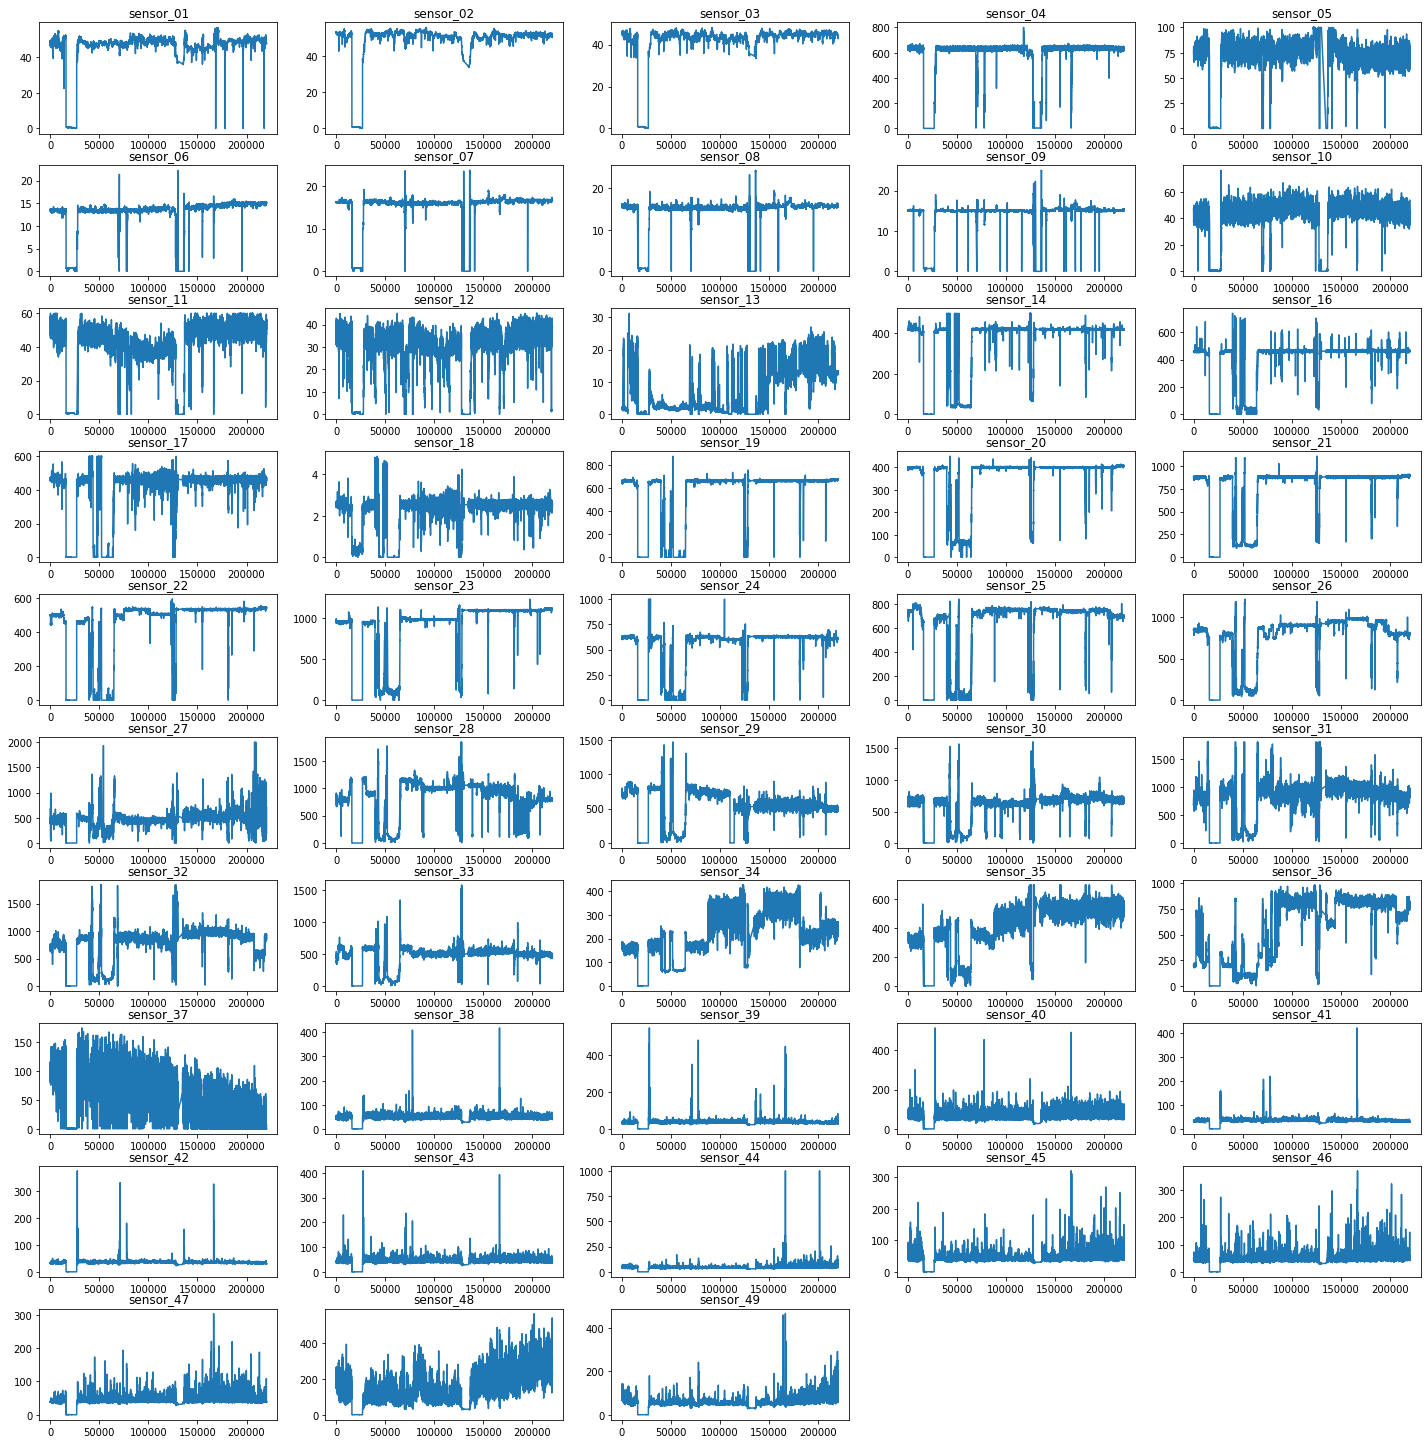

In [95]:
# subplot matrix
fig, axes = plt.subplots(10, 5, figsize=(20,20))
fig.tight_layout()

for col, ax in zip(sensor.columns[1:-1], axes.flat):
    sensor[col].plot.line(ax=ax)
    ax.set_title(col)
# disable leftover axes
for ax in axes.flat[sensor.columns[1:-1].size:]:
    ax.set_axis_off()

okay, scaling sanity check passed. lets start splitting the data to prepare it for training in dGAN.

NOTE: data generated will be in the shape of data passed in for training. so if we pass in samples of 10 rows per, it will only generate a sample of 10 rows.

we have 10,080 rows of data now, which corresponds to 10,080 minutes of data = 168 hours of data = 7 days of data.

I'm going to try splitting the data into two hour segments - giving us 84 120row/minute readings.

In [74]:
# dropping timestamp col
features = unscaled_data_df.to_numpy()
print(features.shape)

# number of samples to split into
n = features.shape[0] // 120
print(n)

# reshape the data accordingly
features = features[:(n*120),:].reshape(-1, 120, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(10080, 48)
84
(84, 120, 48)


In [16]:
# Recommended to train with a GPU - am not for now.
torch.cuda.is_available()

False

In [75]:
# set up DGAN config.
config = DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=12,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True, # already scaled
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

model = DGAN(config)

In [76]:
model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

2022-08-04 23:39:09,832 : MainThread : INFO : epoch: 0
/opt/app-root/lib64/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
2022-08-04 23:39:12,009 : MainThread : INFO : epoch: 1
2022-08-04 23:39:13,621 : MainThread : INFO : epoch: 2
2022-08-04 23:39:13,999 : MainThread : INFO : epoch: 3
2022-08-04 23:39:14,342 : MainThread : INFO : epoch: 4
2022-08-04 23:39:14,658 : MainThread : INFO : epoch: 5
2022-08-04 23:39:14,996 : MainThread : INFO : epoch: 6
2022-08-04 23:39:15,310 : MainThread : INFO : epoch: 7
2022-08-04 23:39:15,622 : MainThread : INFO : epoch: 8
2022-08-04 23:39:15,941 : MainThread : INFO : epoch: 9
2022-08-04 23:39:16,258 : MainThread : INFO : epoch: 10
2022-08-04 23:39:16,561 : MainThread : INFO : epoch: 11
2022-08-04 23:39:16,868 : MainThread : INFO : epoch: 12
2022-08-04 23:39:17,179 : Ma

finished training at around 6-7 mins on large notebook image - not bad! 

In [77]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(100)

In [78]:
# Weak correlations between synthetic and real data 
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=sensor_cols)
unscaled_data_df.corrwith(synthetic_df)

sensor_01    0.005648
sensor_02   -0.044992
sensor_03   -0.036681
sensor_04    0.031594
sensor_05   -0.017146
sensor_06   -0.037689
sensor_07   -0.121049
sensor_08   -0.046603
sensor_09   -0.100280
sensor_10   -0.018602
sensor_11    0.009955
sensor_12    0.033953
sensor_13    0.073635
sensor_14    0.085468
sensor_16    0.074334
sensor_17    0.048630
sensor_18    0.047128
sensor_19    0.106312
sensor_20    0.106753
sensor_21    0.103088
sensor_22    0.077206
sensor_23    0.036148
sensor_24    0.094155
sensor_25    0.157897
sensor_26    0.095969
sensor_27    0.057672
sensor_28    0.068137
sensor_29   -0.031781
sensor_30    0.001506
sensor_31   -0.008815
sensor_32    0.073578
sensor_33    0.066050
sensor_34    0.019378
sensor_35    0.010543
sensor_36   -0.082533
sensor_37    0.124732
sensor_38   -0.024914
sensor_39   -0.013539
sensor_40   -0.018206
sensor_41   -0.017607
sensor_42   -0.027466
sensor_43   -0.017423
sensor_44   -0.022399
sensor_45    0.018363
sensor_46   -0.007671
sensor_47 

<AxesSubplot:>

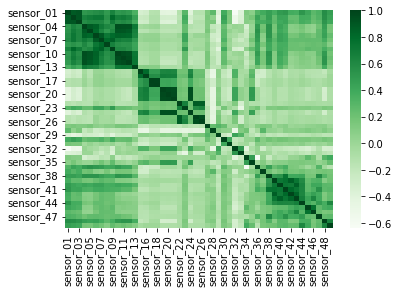

In [80]:
sns.heatmap(unscaled_data_df.corr(),cmap='Greens')

<AxesSubplot:>

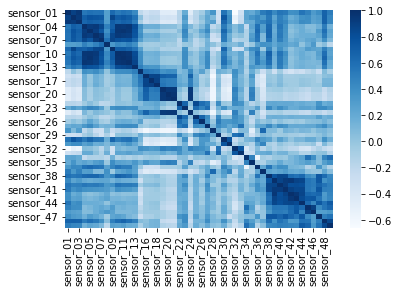

In [81]:
sns.heatmap(synthetic_df.corr(),cmap='Blues')

# Mutlicorrelation seems to be a problem in both the real and synthetic data; but at least this means that the synthetic data is mimicing the real data well.

In [83]:
# Save to a csv file for better readability
unscaled_data_df.corr().to_csv("unscaled_df_corr.csv")
synthetic_df.corr().to_csv("synthetic_df_corr.csv")

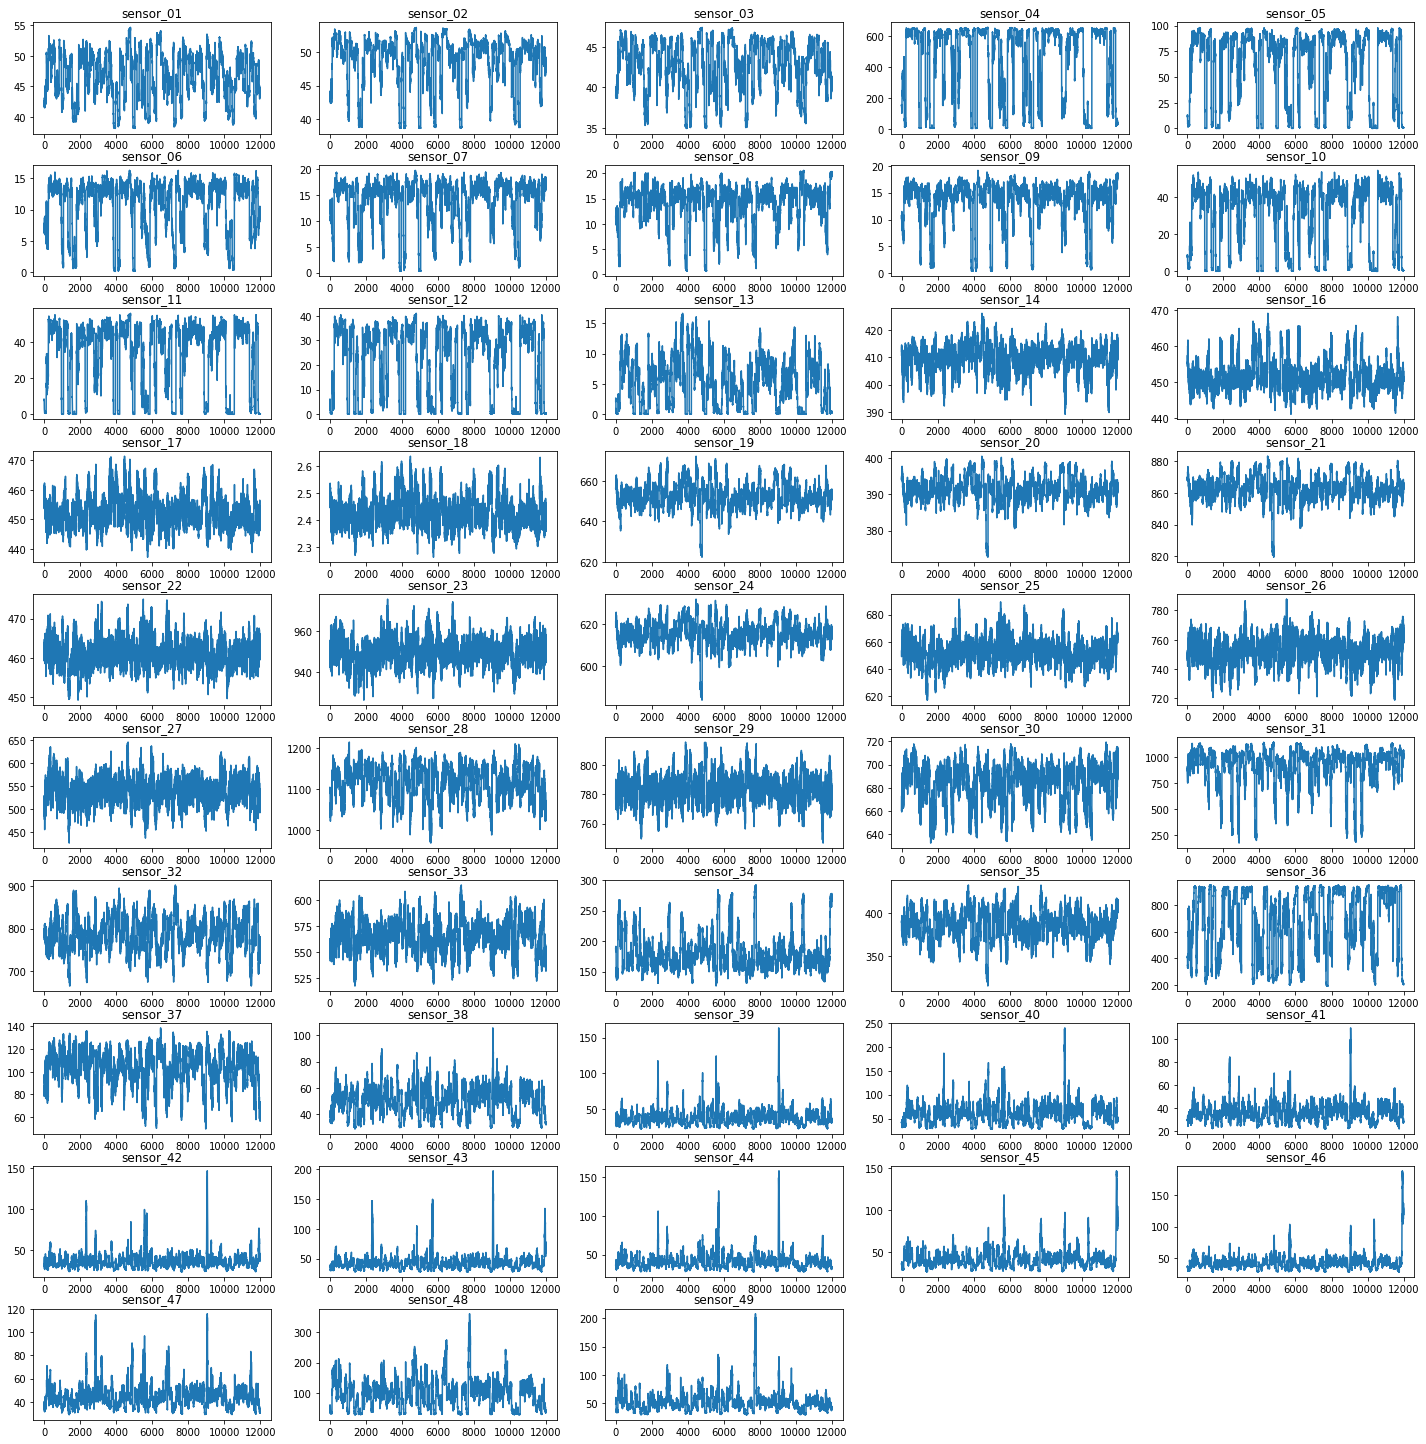

In [94]:
fig, axes = plt.subplots(10, 5, figsize=(20,20))
fig.tight_layout()

for col, ax in zip(synthetic_df.columns, axes.flat):
    synthetic_df[col].plot.line(ax=ax)
    ax.set_title(col)
# disable leftover axes
for ax in axes.flat[synthetic_df.columns.size:]:
    ax.set_axis_off()

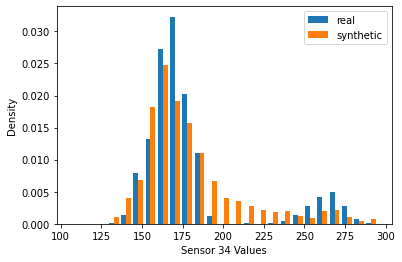

In [92]:
# Compare distribution of sensor_34 values

plt.hist([unscaled_data_df['sensor_34'], synthetic_df['sensor_34']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 34 Values")
plt.ylabel("Density")
plt.show()

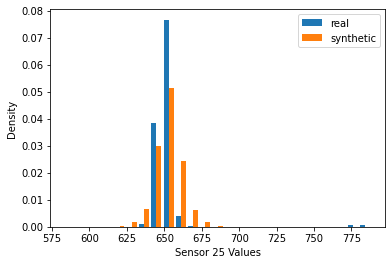

In [86]:
# Compare distribution of sensor_25 values

plt.hist([unscaled_data_df['sensor_25'], synthetic_df['sensor_25']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 25 Values")
plt.ylabel("Density")
plt.show()

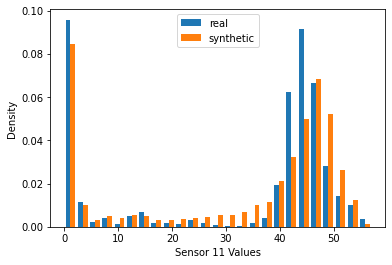

In [87]:
# Compare distribution of sensor_11 values

plt.hist([unscaled_data_df['sensor_11'], synthetic_df['sensor_11']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 11 Values")
plt.ylabel("Density")
plt.show()

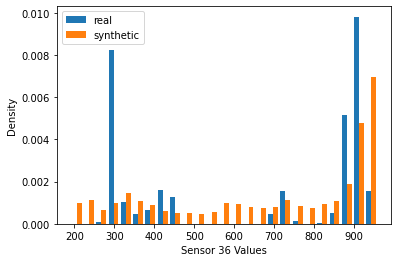

In [88]:
# Compare distribution of sensor_36 values

plt.hist([unscaled_data_df['sensor_36'], synthetic_df['sensor_36']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 36 Values")
plt.ylabel("Density")
plt.show()

In [96]:
# saving model for future use 
model.save("dgan_model_0.pt")

# X = model.load("dgan_model_0.pt")

# X